In [1]:
import sys
sys.path.append("models/raster")

import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from auxiliary.visualization import visualize_losses, visualize_confusion_matrix
from auxiliary.misc import send_notification, get_model_name

from cnn import CNN
from vit import ViT
from dataset_raster import BuildingRasterDataset
from train_raster import train_raster_model

In [2]:
# defining a seed for reproducible results
np.random.seed(69)

In [3]:
# Check if CUDA is available, then MPS, otherwise use CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
    # cluster path
    raster_path = "../scratch/raster"
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    # local path
    raster_path = "../data.nosync/raster"
else:
    device = torch.device("cpu")
    # local path
    raster_path = "../data.nosync/raster"

print(f"Device set to: {device}")

Device set to: mps


In [4]:
# operators are always specified in this order
operator_order = ("elimination", "aggregation", "typification", "displacement", "enlargement", "simplification")

In [5]:
# Define DIN font for plots if working locally
if not torch.cuda.is_available():
    plt.rcParams["font.family"] = "DIN Alternate"

## Elimination model

In [6]:
# define path to training and validation data
path_to_training_data = os.path.join(raster_path, "training_data", "elimination", "training")
path_to_validation_data = os.path.join(raster_path, "training_data", "elimination", "validation")
path_to_test_data = os.path.join(raster_path, "training_data", "elimination", "test")

# define input parameters
elimination_operators = ["elimination"]
attach_roads = True

n_channels = 3 if attach_roads else 2
n_classes = len(elimination_operators)

# Creating model and moving to device
model = CNN(n_channels=n_channels, n_classes=n_classes)
#model = ViT(channels=n_channels, num_classes=n_classes)

model.to(device)
print(f"Using {model}")

learning_rate = 0.0005

criterion = nn.BCEWithLogitsLoss() # Binary cross-entropy loss, applies a sigmoid internally and takes logits as input
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Using CNN with 4,075,585 parameters


In [7]:
# composing various random transforms that should be applied to the data
transform = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomRotation(degrees=(0,0)),
        transforms.RandomRotation(degrees=(90,90)),
        transforms.RandomRotation(degrees=(180,180)),
        transforms.RandomRotation(degrees=(270,270))
    ]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5)
])

# construct training DataLoader
training_set = BuildingRasterDataset(path_to_training_data, 
                                     operators=elimination_operators, 
                                     attach_roads=attach_roads, 
                                     transform=transform, 
                                     subset=1000)

# construct validation DataLoader (no shuffling)
validation_set = BuildingRasterDataset(path_to_validation_data, 
                                       operators=elimination_operators, 
                                       attach_roads=attach_roads, 
                                       transform=transform,
                                       subset=1000)

# construct test DataLoader (no transformations, no shuffling)
test_set = BuildingRasterDataset(path_to_test_data, 
                                 operators=elimination_operators, 
                                 attach_roads=attach_roads, 
                                 transform=None,
                                 subset=1000)

print(f"{len(training_set):,} samples in the training set.")
print(f"{len(validation_set):,} samples in the validation set.")
print(f"{len(test_set):,} samples in the test set.")

1,000 samples in the training set.
1,000 samples in the validation set.
1,000 samples in the test set.


### Model training

In [8]:
# number of epochs and batch size
n_epochs = 10
batch_size = 16

model, training_losses, validation_losses, training_time = train_raster_model(model=model, 
                                                                              device=device, 
                                                                              optimizer=optimizer, 
                                                                              criterion=criterion, 
                                                                              n_epochs=n_epochs, 
                                                                              batch_size=batch_size, 
                                                                              validate=True, 
                                                                              training_set=training_set, 
                                                                              validation_set=validation_set, 
                                                                              shuffle_training_set=True, 
                                                                              shuffle_validation_set=False)

# saving the losses
model_name = get_model_name(model, 
                            ops="eli", 
                            attach_roads=attach_roads, 
                            n_samples=len(training_set), 
                            n_epochs=n_epochs, 
                            batch_size=batch_size) + ".csv"
losses_path = os.path.join(raster_path, "model_outputs", "elimination", "losses", model_name)

# creating a DataFrame with loss values
losses_df = pd.DataFrame({"epoch": list(range(1, n_epochs+1)), 
                          "training_loss": training_losses, 
                          "validation_loss": validation_losses})

# save to CSV
losses_df.to_csv(losses_path, index=False)

# if working on ScienceCluster, send notification that training has finished
if torch.cuda.is_available():
    send_notification(model=model, 
                      email_address="joris.senn@uzh.ch", 
                      n_samples=len(training_set), 
                      n_epochs=n_epochs, 
                      batch_size=batch_size, 
                      time=training_time)

epoch 1/10, step 6/63
epoch 1/10, step 12/63
epoch 1/10, step 18/63
epoch 1/10, step 24/63
epoch 1/10, step 30/63
epoch 1/10, step 36/63
epoch 1/10, step 42/63
epoch 1/10, step 48/63
epoch 1/10, step 54/63
epoch 1/10, step 60/63
epoch 1 finished, training loss: 0.690, validation loss: 0.692
epoch 2/10, step 6/63
epoch 2/10, step 12/63
epoch 2/10, step 18/63
epoch 2/10, step 24/63
epoch 2/10, step 30/63
epoch 2/10, step 36/63
epoch 2/10, step 42/63
epoch 2/10, step 48/63
epoch 2/10, step 54/63
epoch 2/10, step 60/63
epoch 2 finished, training loss: 0.690, validation loss: 0.685
epoch 3/10, step 6/63
epoch 3/10, step 12/63
epoch 3/10, step 18/63
epoch 3/10, step 24/63
epoch 3/10, step 30/63
epoch 3/10, step 36/63
epoch 3/10, step 42/63
epoch 3/10, step 48/63
epoch 3/10, step 54/63
epoch 3/10, step 60/63
epoch 3 finished, training loss: 0.688, validation loss: 0.684
epoch 4/10, step 6/63
epoch 4/10, step 12/63
epoch 4/10, step 18/63
epoch 4/10, step 24/63
epoch 4/10, step 30/63
epoch 4/10

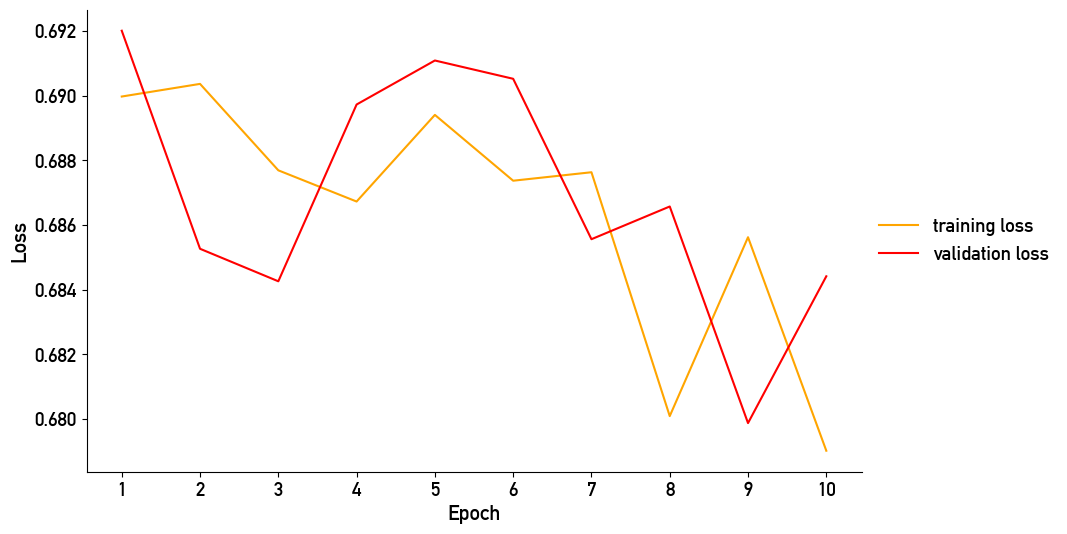

In [9]:
loss_path = os.path.join(raster_path, "model_outputs", "elimination", "losses")
visualize_losses([model_name], loss_path)

### Accuracy metrics after training

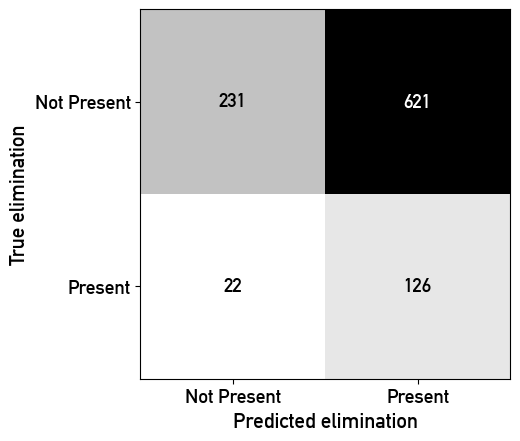

Accuracy: 0.357
Precision: 0.169
Recall: 0.851
F1 Score: 0.282


In [10]:
# creating test DataLoader
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

# switch to evaluation mode
model.eval()

# storing the predictions and true labels from every batch
true_elimination = []
pred_elimination = []

# prediction evaluations should not be part of the computational graph, gradients should not be tracked
with torch.no_grad():
    for block, operators in test_loader:
        
        # moving the features to device
        block = block.to(device)
        operators = operators.to(device)

        # prediction on the trained model results in logits, sigmoid needs to be applied to obtain probabilities
        pred_operators_logits = model(block)
        pred_operators = torch.sigmoid(pred_operators_logits)
        pred_operators_labels = (pred_operators > 0.5).float()  # thresholding

        # extracting true and predicted elimination
        true_elimination_batch = operators[:,0]
        pred_elimination_batch = pred_operators_labels[:,0]

        # collect data for metrics calculation
        true_elimination.append(true_elimination_batch.cpu())
        pred_elimination.append(pred_elimination_batch.cpu())

# convert lists to tensors
true_elimination = torch.cat(true_elimination)
pred_elimination = torch.cat(pred_elimination)

# calculate metrics
conf_matrix = confusion_matrix(true_elimination.numpy(), pred_elimination.numpy())
accuracy = accuracy_score(true_elimination.numpy(), pred_elimination.numpy())
precision = precision_score(true_elimination.numpy(), pred_elimination.numpy())
recall = recall_score(true_elimination.numpy(), pred_elimination.numpy())
f1 = f1_score(true_elimination.numpy(), pred_elimination.numpy())

# saving the accuracy metrics
model_name = get_model_name(model, 
                            ops="eli", 
                            attach_roads=attach_roads, 
                            n_samples=len(training_set), 
                            n_epochs=n_epochs, 
                            batch_size=batch_size) + ".csv"
metrics_path = os.path.join(raster_path, "model_outputs", "elimination", "metrics", model_name)

# creating a DataFrame with loss values
metrics_df = pd.DataFrame({"operator": ["elimination"],
                           "accuracy": [accuracy], 
                           "precision": [precision],
                           "recall": [recall],
                           "f1-score": [f1]})

# save to CSV
metrics_df.to_csv(metrics_path, index=False)

# display the confusion matrix
visualize_confusion_matrix(conf_matrix, operator="elimination")

# print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

### Saving the model

In [11]:
# save the trained model to disk
path_to_models = os.path.join(raster_path, "models", "elimination")

model_name = get_model_name(model, 
                            ops="eli", 
                            attach_roads=attach_roads, 
                            n_samples=len(training_set), 
                            n_epochs=n_epochs, 
                            batch_size=batch_size) + ".pth"

torch.save({"epoch": n_epochs,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": criterion,
            }, os.path.join(path_to_models, model_name))

## Selection model

In [12]:
# define path to training and validation data
path_to_training_data = os.path.join(raster_path, "training_data", "selection", "training")
path_to_validation_data = os.path.join(raster_path, "training_data", "selection", "validation")
path_to_test_data = os.path.join(raster_path, "training_data", "selection", "test")

# define input parameters
selection_operators = ["aggregation", "typification", "displacement", "enlargement"]
attach_roads = True

n_channels = 3 if attach_roads else 2
n_classes = len(selection_operators)

# Creating model and moving to device
model = CNN(n_channels=n_channels, n_classes=n_classes)
#model = ViT(channels=n_channels, num_classes=n_classes)

model.to(device)
print(f"Using {model}")

learning_rate = 0.0005

criterion = nn.BCEWithLogitsLoss() # Binary cross-entropy loss, applies a sigmoid internally and takes logits as input
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Using CNN with 8,893,252 parameters


In [13]:
# composing various random transforms that should be applied to the data
transform = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomRotation(degrees=(0,0)),
        transforms.RandomRotation(degrees=(90,90)),
        transforms.RandomRotation(degrees=(180,180)),
        transforms.RandomRotation(degrees=(270,270))
    ]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5)
])

# construct training DataLoader
training_set = BuildingRasterDataset(path_to_training_data, 
                                     operators=selection_operators, 
                                     attach_roads=attach_roads, 
                                     transform=transform,
                                     subset=1000)

# construct validation DataLoader (no shuffling)
validation_set = BuildingRasterDataset(path_to_validation_data, 
                                       operators=selection_operators, 
                                       attach_roads=attach_roads, 
                                       transform=transform,
                                       subset=1000)

# construct test DataLoader (no transformations, no shuffling)
test_set = BuildingRasterDataset(path_to_test_data, 
                                 operators=selection_operators, 
                                 attach_roads=attach_roads, 
                                 transform=None,
                                 subset=1000)

print(f"{len(training_set):,} samples in the training set.")
print(f"{len(validation_set):,} samples in the validation set.")
print(f"{len(test_set):,} samples in the test set.")

1,000 samples in the training set.
1,000 samples in the validation set.
1,000 samples in the test set.


### Model training

In [14]:
# number of epochs and batch size
n_epochs = 10
batch_size = 16

model, training_losses, validation_losses, training_time = train_raster_model(model=model, 
                                                                              device=device, 
                                                                              optimizer=optimizer, 
                                                                              criterion=criterion, 
                                                                              n_epochs=n_epochs, 
                                                                              batch_size=batch_size, 
                                                                              validate=True, 
                                                                              training_set=training_set, 
                                                                              validation_set=validation_set, 
                                                                              shuffle_training_set=True, 
                                                                              shuffle_validation_set=False)

# saving the losses
model_name = get_model_name(model, 
                            ops="sel", 
                            attach_roads=attach_roads, 
                            n_samples=len(training_set), 
                            n_epochs=n_epochs, 
                            batch_size=batch_size) + ".csv"
losses_path = os.path.join(raster_path, "model_outputs", "selection", "losses", model_name)

# creating a DataFrame with loss values
losses_df = pd.DataFrame({"epoch": list(range(1, n_epochs+1)), 
                          "training_loss": training_losses, 
                          "validation_loss": validation_losses})

# save to CSV
losses_df.to_csv(losses_path, index=False)

# if working on ScienceCluster, send notification that training has finished
if torch.cuda.is_available():
    send_notification(model=model, 
                      email_address="joris.senn@uzh.ch", 
                      n_samples=len(training_set), 
                      n_epochs=n_epochs, 
                      batch_size=batch_size, 
                      time=training_time)

epoch 1/10, step 6/63
epoch 1/10, step 12/63
epoch 1/10, step 18/63
epoch 1/10, step 24/63
epoch 1/10, step 30/63
epoch 1/10, step 36/63
epoch 1/10, step 42/63
epoch 1/10, step 48/63
epoch 1/10, step 54/63
epoch 1/10, step 60/63
epoch 1 finished, training loss: 0.692, validation loss: 0.688
epoch 2/10, step 6/63
epoch 2/10, step 12/63
epoch 2/10, step 18/63
epoch 2/10, step 24/63
epoch 2/10, step 30/63
epoch 2/10, step 36/63
epoch 2/10, step 42/63
epoch 2/10, step 48/63
epoch 2/10, step 54/63
epoch 2/10, step 60/63
epoch 2 finished, training loss: 0.685, validation loss: 0.690
epoch 3/10, step 6/63
epoch 3/10, step 12/63
epoch 3/10, step 18/63
epoch 3/10, step 24/63
epoch 3/10, step 30/63
epoch 3/10, step 36/63
epoch 3/10, step 42/63
epoch 3/10, step 48/63
epoch 3/10, step 54/63
epoch 3/10, step 60/63
epoch 3 finished, training loss: 0.683, validation loss: 0.670
epoch 4/10, step 6/63
epoch 4/10, step 12/63
epoch 4/10, step 18/63
epoch 4/10, step 24/63
epoch 4/10, step 30/63
epoch 4/10

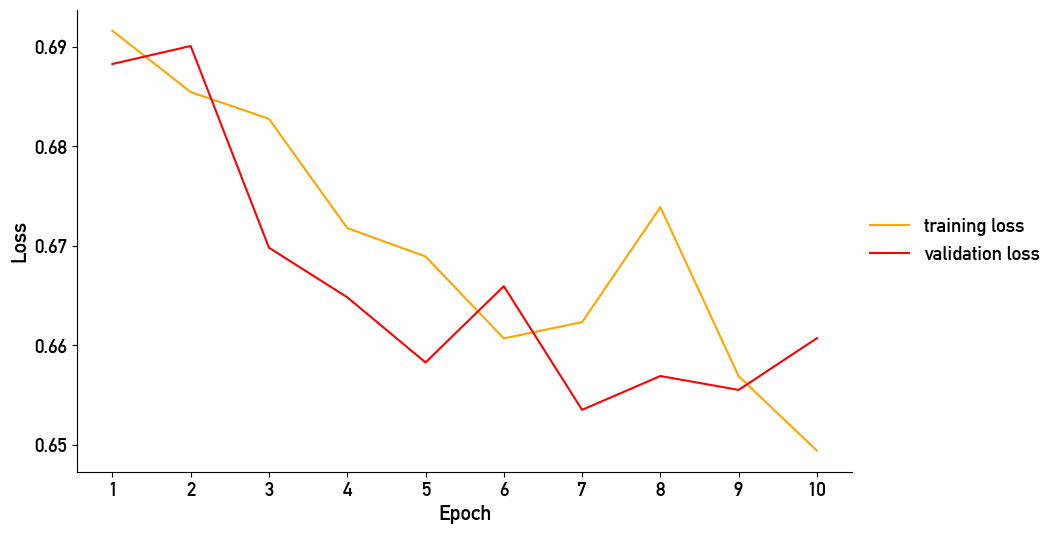

In [15]:
loss_path = os.path.join(raster_path, "model_outputs", "selection", "losses")
visualize_losses([model_name], loss_path)

### Accuracy metrics after training

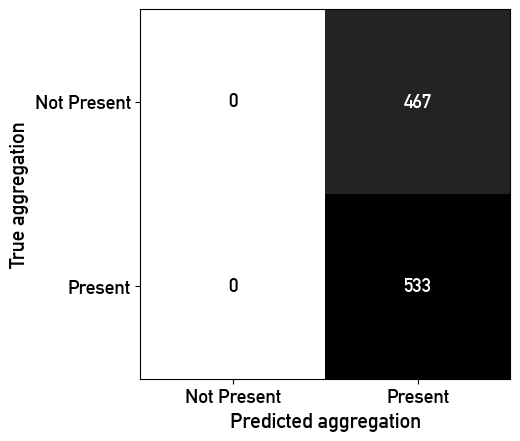

Accuracy: 0.533
Precision: 0.533
Recall: 1.000
F1 Score: 0.695


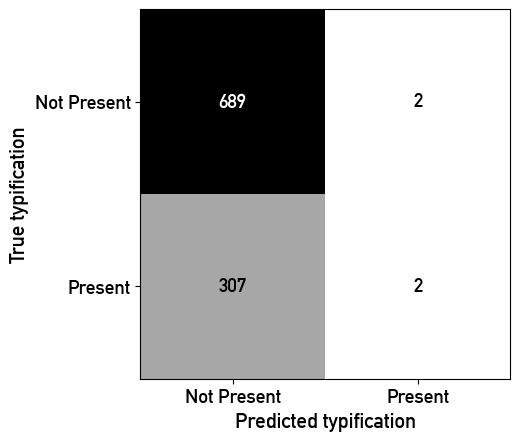

Accuracy: 0.691
Precision: 0.500
Recall: 0.006
F1 Score: 0.013


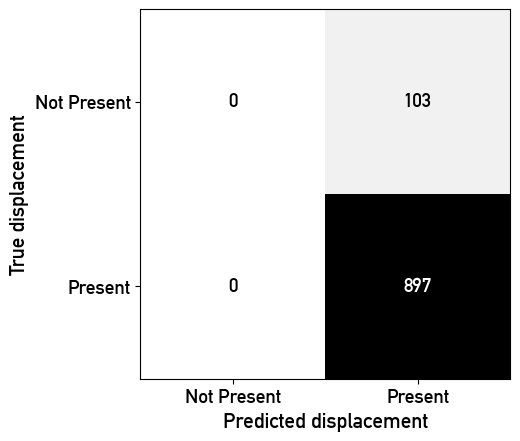

Accuracy: 0.897
Precision: 0.897
Recall: 1.000
F1 Score: 0.946


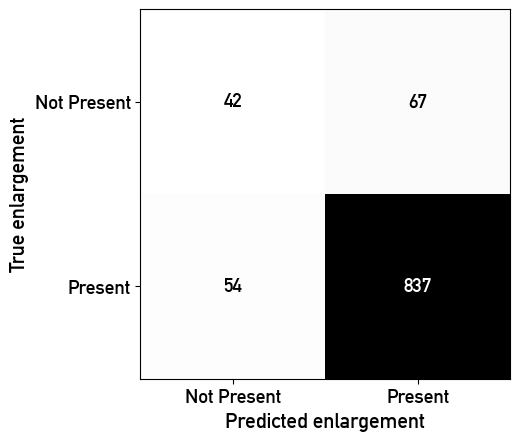

Accuracy: 0.879
Precision: 0.926
Recall: 0.939
F1 Score: 0.933


In [16]:
# creating test DataLoader
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

# switch to evaluation mode
model.eval()

# storing the predictions and true labels from every batch for every operator
true_operators_all = {}
pred_operators_all = {}

for operator_name in selection_operators:
    true_operators_all[operator_name] = []
    pred_operators_all[operator_name] = []

# prediction evaluations should not be part of the computational graph, gradients should not be tracked
with torch.no_grad():
    for block, operators in test_loader:
        
        # moving the features to device
        block = block.to(device)
        operators = operators.to(device)

        # prediction on the trained model results in logits, sigmoid needs to be applied to obtain probabilities
        pred_operators_logits = model(block)
        pred_operators = torch.sigmoid(pred_operators_logits)
        pred_operators_labels = (pred_operators > 0.5).float()  # thresholding

        # storing true labels and predictions for every operator
        for i, operator_name in enumerate(selection_operators):
            # extracting true and predicted operator
            true_operator_batch = operators[:,i]
            pred_operator_batch = pred_operators_labels[:,i]

            # collect data for metrics calculation
            true_operators_all[operator_name].append(true_operator_batch.cpu())
            pred_operators_all[operator_name].append(pred_operator_batch.cpu())

metrics = {"operator": [], 
           "accuracy": [], 
           "precision": [], 
           "recall": [], 
           "f1_score": []}

for operator_name in selection_operators:
    # convert lists to tensors
    cur_true_operator = torch.cat(true_operators_all[operator_name])
    cur_pred_operator = torch.cat(pred_operators_all[operator_name])

    # calculate metrics of the current operator
    conf_matrix = confusion_matrix(cur_true_operator.numpy(), cur_pred_operator.numpy())
    accuracy = accuracy_score(cur_true_operator.numpy(), cur_pred_operator.numpy())
    precision = precision_score(cur_true_operator.numpy(), cur_pred_operator.numpy())
    recall = recall_score(cur_true_operator.numpy(), cur_pred_operator.numpy())
    f1 = f1_score(cur_true_operator.numpy(), cur_pred_operator.numpy())

    # store the metrics of the current operator
    metrics["operator"].append(operator_name)
    metrics["accuracy"].append(accuracy)
    metrics["precision"].append(precision)
    metrics["recall"].append(recall)
    metrics["f1_score"].append(f1)

    # display the confusion matrix
    visualize_confusion_matrix(conf_matrix, operator=operator_name)
    
    # print metrics
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")

# saving the accuracy metrics
model_name = get_model_name(model, 
                            ops="sel", 
                            attach_roads=attach_roads, 
                            n_samples=len(training_set), 
                            n_epochs=n_epochs, 
                            batch_size=batch_size) + ".csv"
metrics_path = os.path.join(raster_path, "model_outputs", "selection", "metrics", model_name)

# creating a DataFrame with loss values
metrics_df = pd.DataFrame(metrics)

# save to CSV
metrics_df.to_csv(metrics_path, index=False)

### Saving the model

In [17]:
# save the trained model to disk
path_to_models = os.path.join(raster_path, "models", "selection")

model_name = get_model_name(model, 
                            ops="sel", 
                            attach_roads=attach_roads, 
                            n_samples=len(training_set), 
                            n_epochs=n_epochs, 
                            batch_size=batch_size) + ".pth"

torch.save({"epoch": n_epochs,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": criterion,
            }, os.path.join(path_to_models, model_name))